In [70]:
import pandas as pd
import numpy as np
df_train = pd.read_json("C:/Users/xiyan_wang/Documents/GitHub/Rental-Listing/Data/train1.json") 
df_test = pd.read_json("C:/Users/xiyan_wang/Documents/GitHub/Rental-Listing/Data/test1.json") 

In [71]:
df_train['train'] = 1
df_test['train'] = 0
df_test.head()
df = pd.concat([df_train, df_test])
print(df_test.shape)
print(df.shape)

(74659, 15)
(124011, 16)


## EDA
  In this section we will explore the quantitavie varaibles in the data and ignore the text and photos for now.
  Let's start from the outcome variable: Interest Level

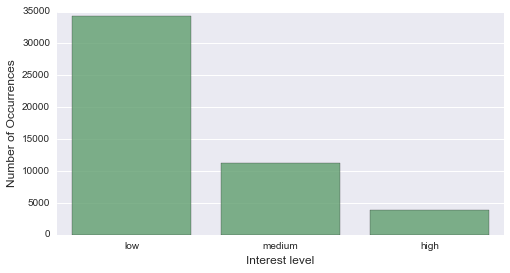

low       34284
medium    11229
high       3839
Name: interest_level, dtype: int64


In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
int_level = df['interest_level'].value_counts()
color = sns.color_palette()

##Interest Level ALONG
plt.figure(figsize=(8,4))
sns.barplot(int_level.index, int_level.values, alpha=0.8, color=color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Interest level', fontsize=12)
plt.show()
print(int_level)

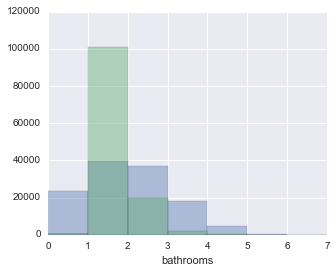

In [7]:
## BED ROOM  and Bath-ROOM
plt.subplots(figsize=(5,4), ncols=1)
sns.distplot(df['bedrooms'], bins = range(0,8,1),kde = False, label = 'Bedrooms')
sns.distplot(df['bathrooms'], bins = range(0,8,1),kde = False, label = 'Bathrooms')
plt.show()

Looks like most of the listed property are 1 bedrooms and most properties have 1-2 bathrooms

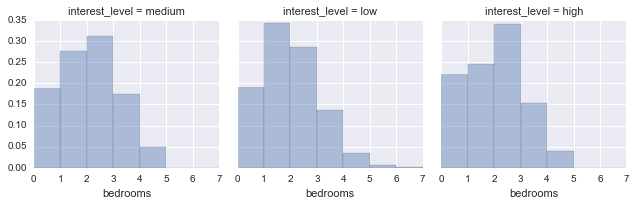

In [8]:
## Distribution of Bed ROOM by interest TYPE
g = sns.FacetGrid(df, col = "interest_level")
g = g.map(sns.distplot, "bedrooms", bins = range(0,8,1),kde = False,norm_hist = True)

### Use Chi-square test to check cell independence

In [9]:
import scipy.stats as stats
bed_tab = pd.crosstab(df['interest_level'],df['bedrooms'],rownames = None, colnames = None,margins = True)
bed_tab = bed_tab.rename(columns = {'All': 'row total'})
print(bed_tab)
expected = np.outer(bed_tab['row total'][0:3],bed_tab.ix['All'][0:9])/49352.00
expected = pd.DataFrame(expected)
expected.index = ['high','low','medium']
observed = pd.crosstab(df['interest_level'],df['bedrooms'])
chi_square_stats = (((expected - observed)**2)/expected).sum().sum()
print expected
print observed
print "chi-square value is %d" %chi_square_stats
crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                      df = 16)   # *

print "Critical value is %d" %crit
p_value = 1 - stats.chi2.cdf(x=chi_square_stats,  # Find the p-value
                             df=16)
print "P value is %d" %p_value

bedrooms           0      1      2     3     4    5   6  7  8  row total
interest_level                                                          
high             847    943   1306   592   149    2   0  0  0       3839
low             6518  11715   9801  4727  1233  243  44  1  2      34284
medium          2110   3094   3516  1957   547    2   2  1  0      11229
All             9475  15752  14623  7276  1929  247  46  2  2      49352
                  0             1             2            3            4  \
high     737.042572   1225.318690   1137.495887   565.986465   150.053311   
low     6582.122305  10942.648079  10158.350867  5054.514184  1340.043686   
medium  2155.835123   3584.033231   3327.153246  1655.499352   438.903003   

                 5          6         7         8  
high     19.213669   3.578254  0.155576  0.155576  
low     171.586724  31.955422  1.389366  1.389366  
medium   56.199607  10.466324  0.455058  0.455058  
bedrooms           0      1     2     3     4

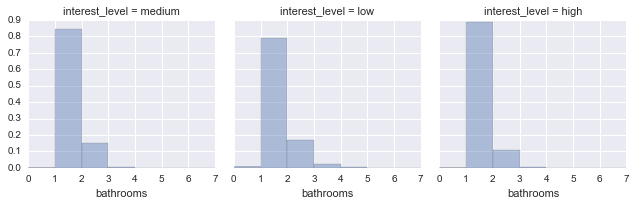

In [10]:
## Distribution of Bed ROOM by interest TYPE
g = sns.FacetGrid(df, col = "interest_level")
g = g.map(sns.distplot, "bathrooms", bins = range(0,8,1),kde = False,norm_hist = True)

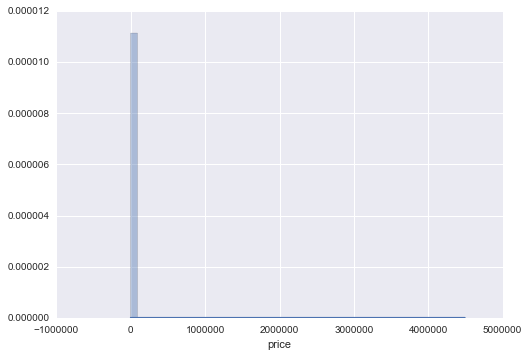

In [11]:
##Price vs Interest Level
#First, price is of course a rather skewed distribution
import numpy as np
sns.distplot(df['price'])
plt.show()

Okay this is ridiculus. My guess is that some property manger put the price per house into the price chart, which explained the off-charts number. So we want to check out what would be a proper range for our first histogram.

In [12]:
price_95p = np.percentile(df['price'],95)
price_99p = np.percentile(df['price'],99)
print 'The 95th percentile of price is: %d'  %price_95p
print 'The 99th percentile of price is: %d'  %price_99p

The 95th percentile of price is: 6875
The 99th percentile of price is: 13000


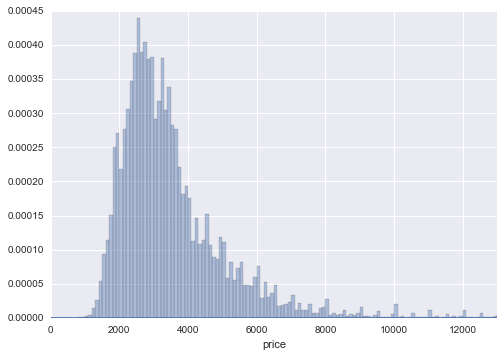

In [13]:
plt.xlim(0,price_99p)
sns.distplot(df['price'],bins = range(0,100000,100),kde = True)
plt.show()

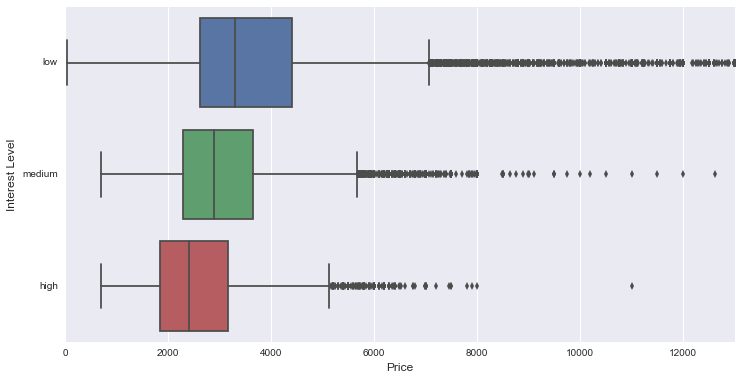

In [14]:
#Let's split it by interest_level
plt.figure(figsize=(12,6))
plt.xlim(0,price_99p)
sns.boxplot(x="price", y="interest_level", data=df, order =['low','medium','high'])
plt.xlabel('Price', fontsize=12)
plt.ylabel('Interest Level', fontsize=12)
plt.show()

## Feature Engineering 

Judging from this boxplot, price would be a pretty good preditor, however, we would like to reduce the amount of outliers before using it for predition!
So some transformation is needed.

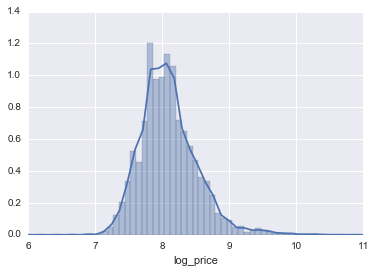

1

In [75]:
## Log transforming Price
df['log_price']=np.log(df['price']+1)
log_price99p = np.log(price_99p)
plt.xlim(6,11)
bins = np.linspace(6.0,11.0,60)

sns.distplot(df['log_price'],bins = bins,kde = True)
plt.show()
df['price'].min()

In [76]:
## add sample weight 
df['weight'] = 0
df.loc[df['interest_level']=='high','weight'] = 4.285144
df.loc[df['interest_level']=='medium','weight'] = 1.465016
df.loc[df['interest_level']=='low','weight'] = 0.479835
df['weight'].value_counts()

0.000000    74659
0.479835    34284
1.465016    11229
4.285144     3839
Name: weight, dtype: int64

## LOGISTICS MODEL

In [32]:
import statsmodels.api as sm
from sklearn import datasets, metrics, cross_validation

In [77]:
df.head()
df_train = df.loc[df["train"]==1]
df_train.shape

(49352, 18)

In [78]:
#
X_train = pd.concat([df_train['bathrooms'],df_train['bedrooms'],df_train['latitude'],df_train['longitude'],df_train['price'],df_train['log_price']],axis = 1)
X_test = pd.concat([df_test['bathrooms'],df_test['bedrooms'],df_test['latitude'],df_test['longitude'],df_test['price'],df_train['log_price']],axis = 1)
X_train -= X_train.mean()
X_test -= X_test.mean()

y_train = df_train['interest_level']
X_train.shape

(49352, 6)

### In Sample Prediction and Accuracy

In [79]:
from sklearn import linear_model,metrics
clf = linear_model.LogisticRegression(C=1., class_weight = 'balanced')
clf.fit(X_train, y_train)
pred = clf.predict(X_train)
print 'insample accuracy is', round(metrics.accuracy_score(y_train,pred),4)

# View confusion matrix
metrics.confusion_matrix(y_true=y_train,  # True labels
                         y_pred=pred) # Predicted labels

insample accuracy is 0.6451


array([[ 1449,  2007,   383],
       [ 2839, 29356,  2089],
       [ 2049,  8146,  1034]])

### Out-of-Sample Prediction

In [80]:
from sklearn import cross_validation
cv = cross_validation.ShuffleSplit(y_train.size, n_iter=50, test_size=.1, random_state=0)
accuracy_vec = []
for k,(train, test) in enumerate(cv):
    clf = linear_model.LogisticRegression(C=1.)
    clf.fit(X_train.iloc[train], y_train.iloc[train])
    pred = clf.predict(X_train.iloc[test])
    accuracy = metrics.accuracy_score(y_train.iloc[test],pred)
    accuracy_vec.append(accuracy)

In [26]:
accuracy_np = np.array(accuracy_vec).mean()
print "mean accuracy of 50 CV is", round(accuracy_np,4)

mean accuracy of 50 CV is 0.6949


In [30]:
df.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address,train/test
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,1
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue,1
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street,1
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street,1
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street,1
